Sebastian Raschka 2014

In [1]:
%load_ext watermark

In [2]:
%watermark -v -u -d -p scipy,scikit-learn,numpy,matplotlib

last updated: 2016-07-11 

CPython 3.5.1
IPython 4.2.0

scipy 0.17.1
scikit-learn 0.17.1
numpy 1.11.0
matplotlib 1.5.1


<font size="1.5em">[More information](https://github.com/rasbt/watermark) about the `watermark` magic command extension.</font>


<hr>
I would be happy to hear your comments and suggestions. 
Please feel free to drop me a note via
[twitter](https://twitter.com/rasbt), [email](mailto:bluewoodtree@gmail.com), or [google+](https://plus.google.com/+SebastianRaschka).
<hr>

<br>
<br>

# Kernel tricks and nonlinear dimensionality reduction via PCA

## Sections

- [Principal Component Analysis](#Principal-Component-Analysis)
- [PCA and linear dimensionality reduction](#PCA-and-linear-dimensionality-reduction)
- [Nonlinear dimensionality reduction](#Nonlinear-dimensionality-reduction)
- [Kernel functions and the kernel trick](Kernel-functions-and-the-kernel-trick)
- [Gaussian RBF Kernel PCA](#Gaussian-RBF-Kernel-PCA)
- [Implementing the RBF kernel PCA step-by-step](#Implementing-the-RBF-kernel-PCA-step-by-step)
- [Examples of RBF Kernel PCA](#Examples-of-RBF-Kernel-PCA)
    - [Half-moon shapes](#Half-moon-shapes)
    - [Concentric circles](#Concentric-circles)
    - [Swiss roll](#Swiss-roll)
- [Appendix A: Projecting new data](#Appendix-A:-Projecting-new-data)
- [References](#References)

<br>
<br>

**Most machine learning algorithms have been developed and statistically validated for linearly separable data. Popular examples are linear classifiers like Support Vector Machines (SVMs) or the (standard) Principal Component Analysis (PCA) for dimensionality reduction. However, most real world data requires nonlinear methods in order to perform tasks that involve the analysis and discovery of patterns successfully.**

**The focus of this article is to briefly introduce the idea of kernel methods and to implement a Gaussian radius basis function (RBF) kernel that is used to perform nonlinear dimensionality reduction via BF kernel principal component analysis (kPCA).**

<br>
<br>

## Principal Component Analysis

The main purpose of principal component analysis (PCA) is the analysis of data to identify patterns that represent the data "well." The principal components can be understood as new axes of the dataset that maximize the variance along those axes (the eigenvectors of the covariance matrix). In other words, PCA aims to find the axes with maximum variances along which the data is most spread.

![pca overview](../../Images/kernel_pca/pca_1.png)


<br>
<br>

## PCA and linear dimensionality reduction

[[back to top](#Sections)]

A common application of PCA is to reduce the dimensions of the dataset with minimal loss of information.
Here, the entire dataset (*d* dimensions) is projected onto a new subspace (*k* dimensions where *k* < *d*). 
This method of projection is useful in order to reduce the computational costs and the error of parameter estimation ("curse of dimensionality").

The standard PCA approach can be summarized in six simple steps:

![pca overview](../../Images/kernel_pca/pca_2.png)

More details can be found in a previous article ["Implementing a Principal Component Analysis (PCA) in Python step by step"](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html).

<br>
<br>

## Nonlinear dimensionality reduction

[[back to top](#Sections)]

The "classic" PCA approach described above is a linear projection technique that works well if the data is linearly separable. However, in the case of linearly inseparable data, a nonlinear technique is required if the task is to reduce the dimensionality of a dataset.

![linear and nonlinear data](../../Images/kernel_pca/linear_vs_nonlinear.png)




<br>
<br>

## Kernel functions and the kernel trick

[[back to top](#Sections)]

The basic idea to deal with linearly inseparable data is to project it onto a higher dimensional space where it becomes linearly separable. Let us call this nonlinear mapping function $\phi$ so that the mapping of a sample $\mathbf{x}$ can be written as $\mathbf{x} \rightarrow \phi (\mathbf{x})$, which is called "kernel function." 

Now, the term "kernel" describes a function that calculates the dot product of the images of the samples $\mathbf{x}$ under $\phi$.


\begin{equation}\kappa(\mathbf{x_i, x_j}) =  \phi (\mathbf{x_i}) \phi (\mathbf{x_j})^T    \end{equation}

More details about the derivation of this equation are provided in this excellent review article by Quan Wang: [Kernel Principal Component Analysis and its Applications in Face Recognition and Active Shape Models](http://arxiv.org/abs/1207.3538).[[1](#References)]



<br>

In other words, the function $\phi$ maps the original d-dimensional features into a larger, k-dimensional feature space by creating nononlinear combinations of the original features. For example, if $\mathbf{x}$ consists of 2 features:

\begin{equation} \mathbf{x} = \big[x_1 \quad x_2\big]^T \quad \quad \mathbf{x} \in I\!R^d\\
\Downarrow \phi \\
 \mathbf{x}' = \big[x_1 \quad x_2 \quad x_1 x_2 \quad x_{1}^2 \quad x_1 x_{2}^3 \quad \dots \big]^T \quad \quad \mathbf{x} \in I\!R^k (k >> d) \end{equation}



Often, the mathematical definition of the RBF kernel is written and implemented as

\begin{equation} \kappa(\mathbf{x_i, x_j}) = exp\bigg(- \gamma \; \lVert\mathbf{x_i - x_j }\rVert^{2}_{2} \bigg)\end{equation}

where $\textstyle\gamma = \tfrac{1}{2\sigma^2}$ is a free parameter that is to be optimized. 

<br>
<br>

## Gaussian radial basis function (RBF) Kernel PCA

[[back to top](#Sections)]

In the linear PCA approach, we are interested in the principal components that maximize the variance in the dataset. This is done by extracting the eigenvectors (principle components) that correspond to the largest eigenvalues based on the covariance matrix:

\begin{equation}\text{Cov} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{x_i} \mathbf{x_i}^T \end{equation}

Bernhard Scholkopf ([Kernel Principal Component Analysis](http://dl.acm.org/citation.cfm?id=299113) [[2](#References)]) generalized this approach for data that was mapped onto the higher dimensional space via a kernel function:

\begin{equation}\text{Cov} = \frac{1}{N} \sum_{i=1}^{N} \phi(\mathbf{x_i}) \phi(\mathbf{x_i})^T \end{equation}

However, in practice the the covariance matrix in the higher dimensional space is not calculated explicitly (kernel trick). Therefore, the implementation of RBF kernel PCA does not yield the principal component axes (in contrast to the standard PCA), but the obtained eigenvectors can be understood as projections of the data onto the principal components.

<br>
<br>

## Implementing the RBF kernel PCA step-by-step

[[back to top](#Sections)]

In order to implement the RBF kernel PCA we just need to consider the following two steps.

##### 1. Computation of the kernel (similarity) matrix.

In this first step, we need to calculate 

\begin{equation} \kappa(\mathbf{x_i, x_j}) = exp\bigg(- \gamma \; \lVert\mathbf{x_i - x_j }\rVert^{2}_{2} \bigg)\end{equation}

for every pair of points. E.g., if we have a dataset of 100 samples, this step would result in a symmetric 100x100 kernel matrix.

##### 2. Eigendecomposition of the kernel matrix.

Since it is not guaranteed that the kernel matrix is centered, we can apply the following equation to do so:

\begin{equation} K' = K - \mathbf{1_N} K - K \mathbf{1_N} + \mathbf{1_N} K \mathbf{1_N} \end{equation}

where $\mathbf{1_N}$ is (like the kernel matrix) a $N\times N$ matrix with all values equal to $\frac{1}{N}$. [[3](#References)]

Now, we have to obtain the eigenvectors of the centered kernel matrix that correspond to the largest eigenvalues. Those eigenvectors are the data points already projected onto the respective principal components. 


Below, we implement those steps in Python to see how those computations work.

<br>
<br>

In [3]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def stepwise_kpca(X, gamma, n_components):
    """
    Implementation of a RBF kernel PCA.
    
    Arguments:
        X: A MxN dataset as NumPy array where the samples are stored as rows (M),
           and the attributes defined as columns (N).
        gamma: A free parameter (coefficient) for the RBF kernel.
        n_components: The number of components to be returned.
    
    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    # Computing the MxM kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding 
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    
    return X_pc

<br>
<br>

# Examples of RBF Kernel PCA

[[back to top](#Sections)]

In this section, we will apply the RBF kernel PCA to different nonlinear sample data in order to perform dimensionality reduction.

<br>

## Half-moon shapes

[[back to top](#Sections)]

We will start with a simple example of 2 half-moon shapes generated by the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function from [scikit-learn](http://scikit-learn.org/stable/index.html).

In [4]:
%matplotlib inline

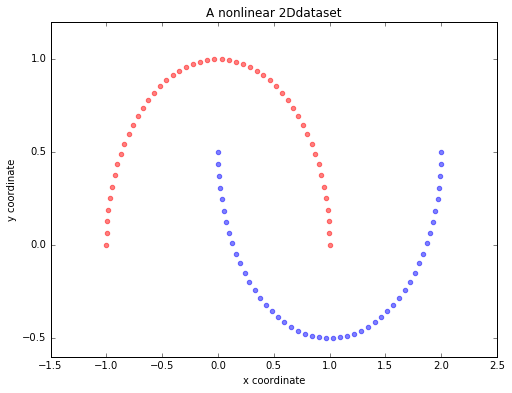

In [5]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

<br>
<br>

### Linear PCA

[[back to top](#Sections)]

Since the two half-moon shapes are linearly inseparable, we expect that the "classic" PCA will fail to give us a "good" representation of the data in 1D space. Here, we will use the [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class that is implemented in scikit-learn to perform the dimensionality reduction.

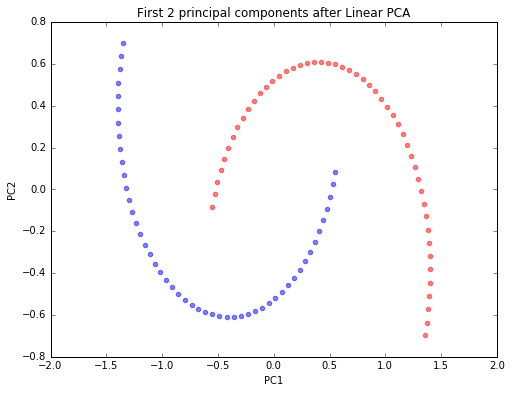

In [6]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

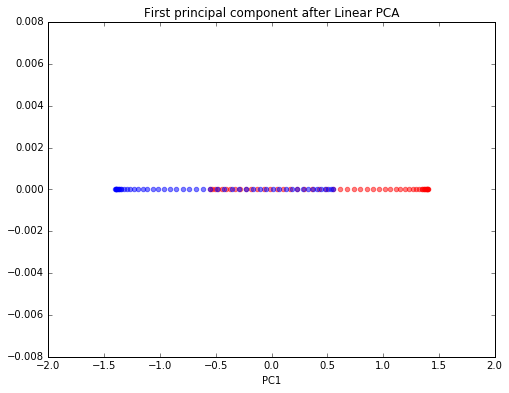

In [7]:
import numpy as np
scikit_pca = PCA(n_components=1)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

As we can see, the resulting principal components do not yield a subspace where the data is linearly separated well. Note that PCA is a unsupervised method and does not "consider" class labels in order to maximize the variance in contrast to [Linear Discriminant Analysis](http://sebastianraschka.com/Articles/2014_python_lda.html). Here, the colors blue and red are just added for visualization purposes to indicate the degree of separation.

<br>
<br>

### Gaussian RBF kernel PCA

[[back to top](#Sections)]

Next, we will perform dimensionality reduction via RBF kernel PCA on our half-moon data. The choice of $\gamma$ depends on the dataset and can be obtained via hyperparameter tuning techniques like Grid Search. Hyperparameter tuning is a broad topic itself, and here I will just use a $\gamma$-value that I found to produce "good" results. 

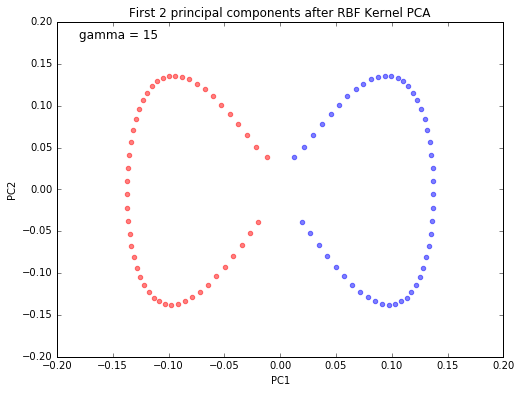

In [8]:
X_pc = stepwise_kpca(X, gamma=15, n_components=2)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], X_pc[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], X_pc[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after RBF Kernel PCA')
plt.text(-0.18, 0.18, 'gamma = 15', fontsize=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

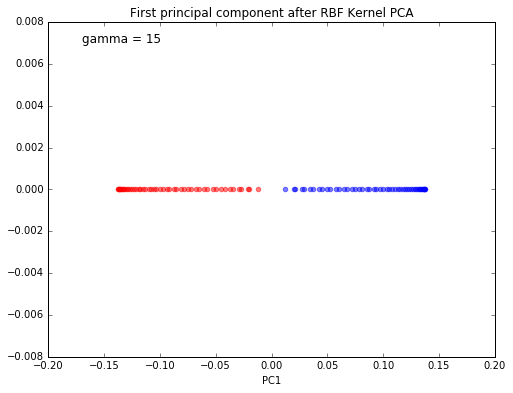

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], np.zeros((50)), color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], np.zeros((50)), color='blue', alpha=0.5)

plt.title('First principal component after RBF Kernel PCA')
plt.text(-0.17, 0.007, 'gamma = 15', fontsize=12)
plt.xlabel('PC1')
plt.show()

We can clearly see that the projection via RBF kernel PCA yielded a subspace where the classes are separated well. Such a subspace can then be used as input for linear classification models, such as Support Vector Machines or naive Bayes classifiers, which will be covered in future articles.

<br>
<br>

### scikit RBF kernel PCA

[[back to top](#Sections)]

For our convenience, there is already an implementation of the [`KernelPCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) in scikit-learn. 
Let us confirm that the results of our implementation is consistent with scikit-learn's approach.

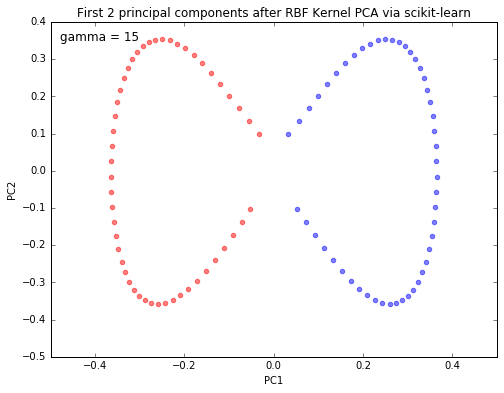

In [10]:
from sklearn.decomposition import KernelPCA

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', alpha=0.5)

plt.text(-0.48, 0.35, 'gamma = 15', fontsize=12)
plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

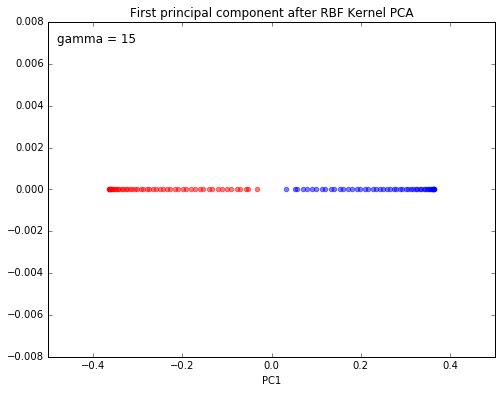

In [11]:
scikit_kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)
plt.text(-0.48, 0.007, 'gamma = 15', fontsize=12)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

<br>
<br>

## Concentric circles

[[back to top](#Sections)]

For our next example, we will have a look at the classic case of 2 concentric circles with random noise produced by scikit-learn's [`make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html).

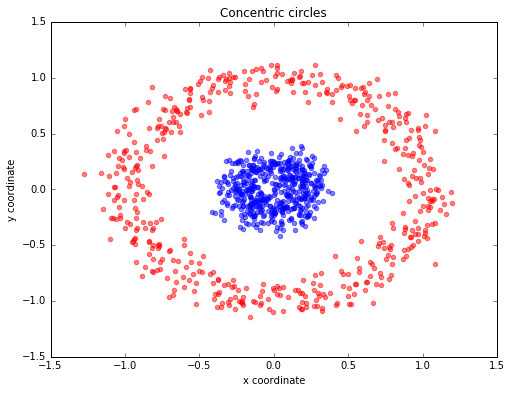

In [14]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Concentric circles')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.savefig('/Users/Sebastian/Desktop/circles1.pdf')

<br>
<br>

### Linear PCA

[[back to top](#Sections)]

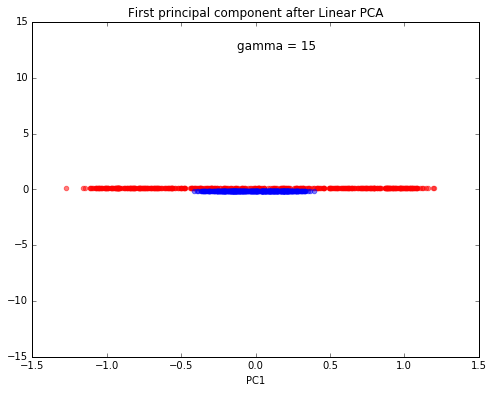

In [15]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], np.zeros((500,1))+0.1, color='red', alpha=0.5)
plt.scatter(X[y==1, 0], np.zeros((500,1))-0.1, color='blue', alpha=0.5)
plt.ylim([-15,15])
plt.text(-0.125, 12.5, 'gamma = 15', fontsize=12)
plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')
plt.savefig('/Users/Sebastian/Desktop/circles2.pdf')

Again, the results obtained via the linear PCA approach does not produce a subspace where the 2 classes are linearly well separated.

<br>
<br>

### Gaussian RBF kernel PCA

[[back to top](#Sections)]

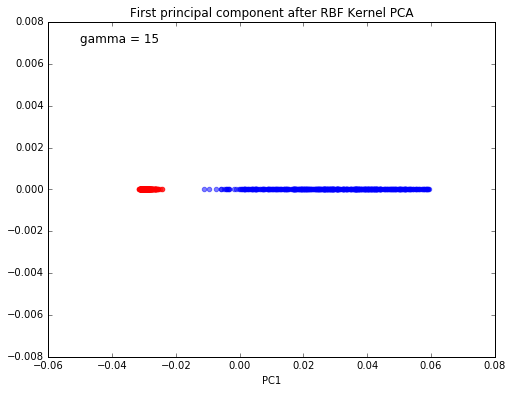

In [16]:
X_pc = stepwise_kpca(X, gamma=15, n_components=1)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], np.zeros((500,1)), color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], np.zeros((500,1)), color='blue', alpha=0.5)
plt.text(-0.05, 0.007, 'gamma = 15', fontsize=12)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')

plt.savefig('/Users/Sebastian/Desktop/circles3.pdf')

And again, this 1-dimensional subspace obtained via Gaussian RBF kernel PCA looks much better in terms of linear class separation.

<br>
<br>

## Swiss roll

[[back to top](#Sections)]

Unrolling the famous Swiss roll is a more challenging task than the examples we have seen above. We will use the [`make_swiss_roll`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_swiss_roll.html) to create 3-dimensional Swiss roll and start with the linear PCA to project the dataset onto a 2D and 1D feature subspace.

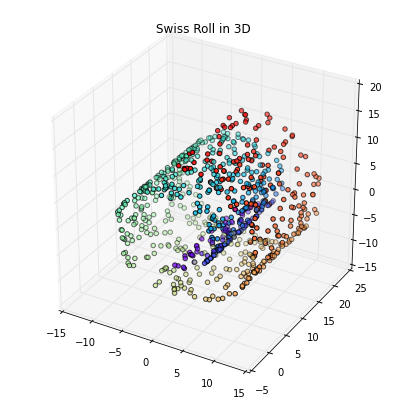

In [15]:
from sklearn.datasets.samples_generator import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

X, color = make_swiss_roll(n_samples=800, random_state=123)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.rainbow)
plt.title('Swiss Roll in 3D')
plt.show()

<br>
<br>

### Linear PCA

[[back to top](#Sections)]

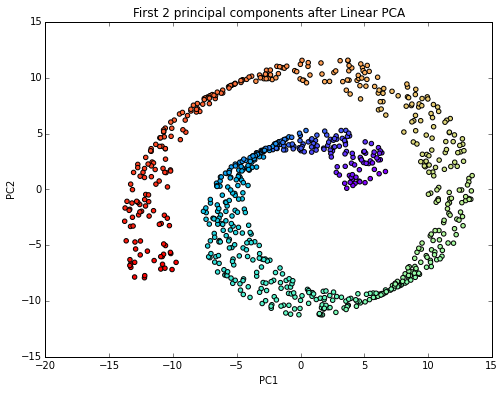

In [16]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[:, 0], X_spca[:, 1], c=color, cmap=plt.cm.rainbow)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

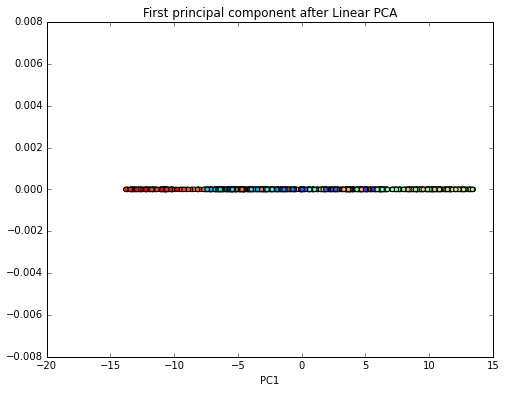

In [17]:
scikit_pca = PCA(n_components=1)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca, np.zeros((800,1)), c=color, cmap=plt.cm.rainbow)
plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')
plt.show()

<br>
<br>

### Gaussian RBF kernel PCA

[[back to top](#Sections)]

I haven't found a good $\gamma$ parameter for the Gaussian RBF kernel for good linear separation of this dataset. The best result I obtained is shown in the following figures.

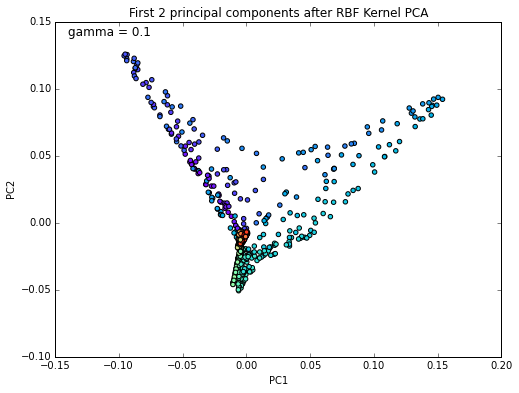

In [18]:
X_pc = stepwise_kpca(X, gamma=0.1, n_components=2)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[:, 0], X_pc[:, 1], c=color, cmap=plt.cm.rainbow)

plt.title('First 2 principal components after RBF Kernel PCA')
plt.text(-0.14, 0.14, 'gamma = 0.1', fontsize=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

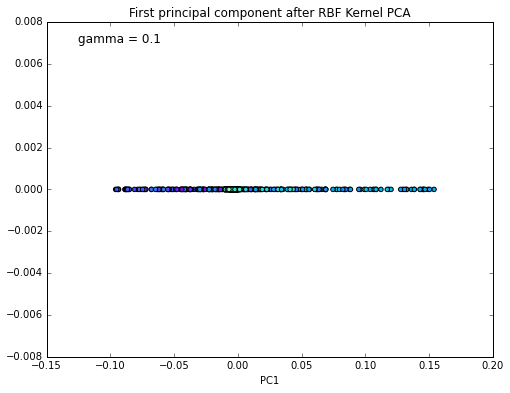

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(X_pc[:,0], np.zeros((800,1)), c=color, cmap=plt.cm.rainbow)

plt.text(-0.125, 0.007, 'gamma = 0.1', fontsize=12)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

<br>
<br>

### Locally-Linear Embedding (LLE)

[[back to top](#Sections)]

In 2000, Sam T. Roweis and Lawrence K. Saul ([Nonlinear dimensionality reduction by locally linear embedding](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.111.3313) [[4](#References)]) introduced an unsupervised learning algorithm called locally linear embedding (LLE) that is better suited to identify patterns in the high-dimensional feature space and solves our problem of nonlinear dimensionality reduction for the Swiss roll.   
Here, we will use the [`locally_linear_embedding`](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html) class from scikit-learn to "unroll" the Swiss roll.

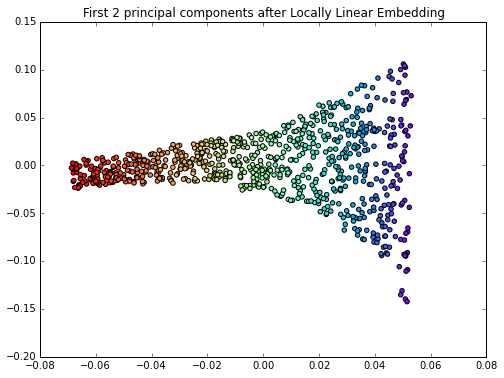

In [20]:
from sklearn.manifold import locally_linear_embedding

X_lle, err = locally_linear_embedding(X, n_neighbors=12, n_components=2)

plt.figure(figsize=(8,6))
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=color, cmap=plt.cm.rainbow)

plt.title('First 2 principal components after Locally Linear Embedding')
plt.show()

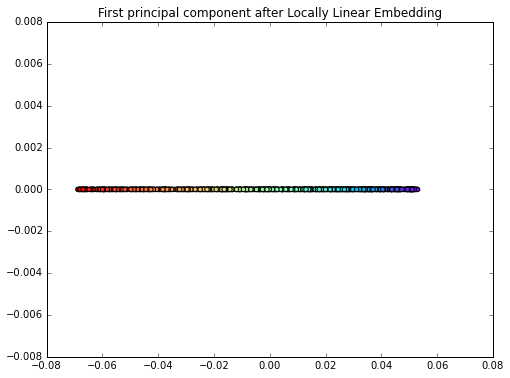

In [21]:
from sklearn.manifold import locally_linear_embedding

X_lle, err = locally_linear_embedding(X, n_neighbors=12, n_components=1)

plt.figure(figsize=(8,6))
plt.scatter(X_lle, np.zeros((800,1)), c=color, cmap=plt.cm.rainbow)

plt.title('First principal component after Locally Linear Embedding')
plt.show()

<br>
<br>

# Appendix A: Projecting new data

[[back to top](#Sections)]

So far, so good, in the sections above, we have been projecting an dataset onto a new feature subspace. However, in a real application, we are usually interested to map new data points onto the same new feature subspace (e.g., if are working with a training and a test dataset in pattern classification tasks).

Remember, when we computed the eigenvectors \\( \mathbf{\alpha} \\) of the centered kernel matrix, those values were actually already the projected datapoints onto the principal component axis \\( \mathbf{g} \\). 

If we want to project a new data point \\( \mathbf{x} \\) onto this principal component axis, we'd need to compute \\(\phi(\mathbf{x})^T  \mathbf{g} \\).

Fortunately, also here, we don't have to compute \\(\phi(\mathbf{x})^T  \mathbf{g} \\) explicitely but use the kernel trick to calculate the RBF kernel between the new data point and every data point \\( j \\) in the training dataset:

$$\phi(\mathbf{x})^T  \mathbf{g}  = \sum_j \alpha_{i} \; \phi(\mathbf{x}) \; \phi(\mathbf{x_j})^T$$

$$=  \sum_j \alpha_{i} \; \kappa(\mathbf{x}, \mathbf{x_j})$$


and the eigenvectors \\( \alpha \\) and eigenvalues \\( \lambda \\) of the Kernel matrix \\(\mathbf{K}\\) satisfy the equation
\\(\mathbf{K} \alpha = \lambda \alpha \\), we just need to normalize the eigenvector by the corresponding eigenvalue.


First, let us modify our original implemenation by returning the corresponding to return also the eigenvalues of the kernel matrix.

In [1]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def stepwise_kpca(X, gamma, n_components):
    """
    Implementation of a RBF kernel PCA.
    
    Arguments:
        X: A MxN dataset as NumPy array where the samples are stored as rows (M),
           and the attributes defined as columns (N).
        gamma: A free parameter (coefficient) for the RBF kernel.
        n_components: The number of components to be returned.
        
    Returns the k eigenvectors (alphas) that correspond to the k largest 
        eigenvalues (lambdas).
    
    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    # Computing the MxM kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K_norm = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # Obtaining eigenvalues in descending order with corresponding 
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K_norm)

    # Obtaining the i eigenvectors (alphas) that corresponds to the i highest eigenvalues (lambdas).
    alphas = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    lambdas = [eigvals[-i] for i in range(1,n_components+1)]
    
    return alphas, lambdas

Now, let's make a new half-moon dataset and project it onto a 1-dimensonal subspace using the RBF kernel PCA:

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = stepwise_kpca(X, gamma=15, n_components=1)

/Users/sebastian/miniconda3/envs/py34/lib/python3.4/site-packages/sklearn/datasets/samples_generator.py:612: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = np.hstack([np.zeros(n_samples_in, dtype=np.intp),


<br>

To confirm that our approach produces the correct results, let's pretend that the 24th point from the half-moon dataset is a new data point  \\( \mathbf{x} \\), and we want to project it onto this new subspace.

In [3]:
x_new = X[25]
X_proj = alphas[25] # original projection

In [4]:
x_new

array([ 1.8713187 ,  0.00928245])

In [5]:
X_proj

array([ 0.07877284])

In [6]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas) 

In [7]:
x_reproj 

array([ 0.07877284])

In [8]:
%matplotlib inline

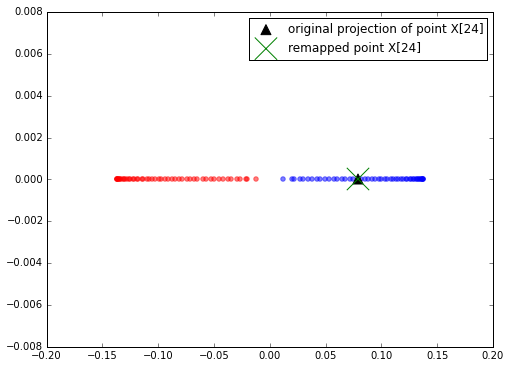

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', alpha=0.5)
plt.scatter(X_proj, 0, color='black', label='original projection of point X[24]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='remapped point X[24]', marker='x', s=500)
plt.legend(scatterpoints=1)
plt.show()

<br>
<br>

# References

[[back to top](#Sections)]

[1] Q. Wang. [Kernel principal component analysis and its applications in face recognition and active shape models](http://arxiv.org/abs/1207.3538). CoRR, abs/1207.3538, 2012.

[2] B. Scholkopf, A. Smola, and K.-R. Muller. [Kernel principal component analysis](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.128.7613). pages 583–588, 1997.

[3] B. Scholkopf, A. Smola, and K.-R. Muller. [Nonlinear component analysis as a kernel eigenvalue problem](http://www.mitpressjournals.org/doi/abs/10.1162/089976698300017467#.VBh9QkuCFHg). Neural computation, 10(5):1299–1319, 1998.

[4] S. T. Roweis and L. K. Saul. [Nonlinear dimensionality reduction by locally linear embedding](http://www.sciencemag.org/content/290/5500/2323.short). Science, 290(5500):2323–2326, 2000.
